In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
if False:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
TEST_DIR = "/kaggle/input/histopathologic-cancer-detection/test/"
TRAIN_DIR = "/kaggle/input/histopathologic-cancer-detection/train/"
LABELS_PATH = "/kaggle/input/histopathologic-cancer-detection/train_labels.csv"

In [3]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from skimage.io import imread

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1_l2

from skimage.io import imread
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

2024-07-01 17:14:10.536338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 17:14:10.536530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 17:14:10.710176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
# labels = pd.read_csv(LABELS_PATH)
#labels

In [4]:
# Function to load a few images from a directory
def load_images_from_folder(folder, num_images):
    images = []
    filenames = os.listdir(folder)[:num_images]
    for filename in filenames:
        img = imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images, filenames

# Function to display images using matplotlib
def display_images(images, filenames, labels, columns=3):
    num_images = len(images)
    rows = (num_images + columns - 1) // columns  # Calculate the number of rows needed
    
    plt.figure(figsize=(15, 5 * rows))
    
    for i, (image, filename) in enumerate(zip(images, filenames)):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(image)
        label = labels.get(filename.split('.')[0], 'Unknown')  # Retrieve label, default to 'Unknown'
        plt.title(f"Label: {label}")
        plt.axis('off')
    
    plt.show()

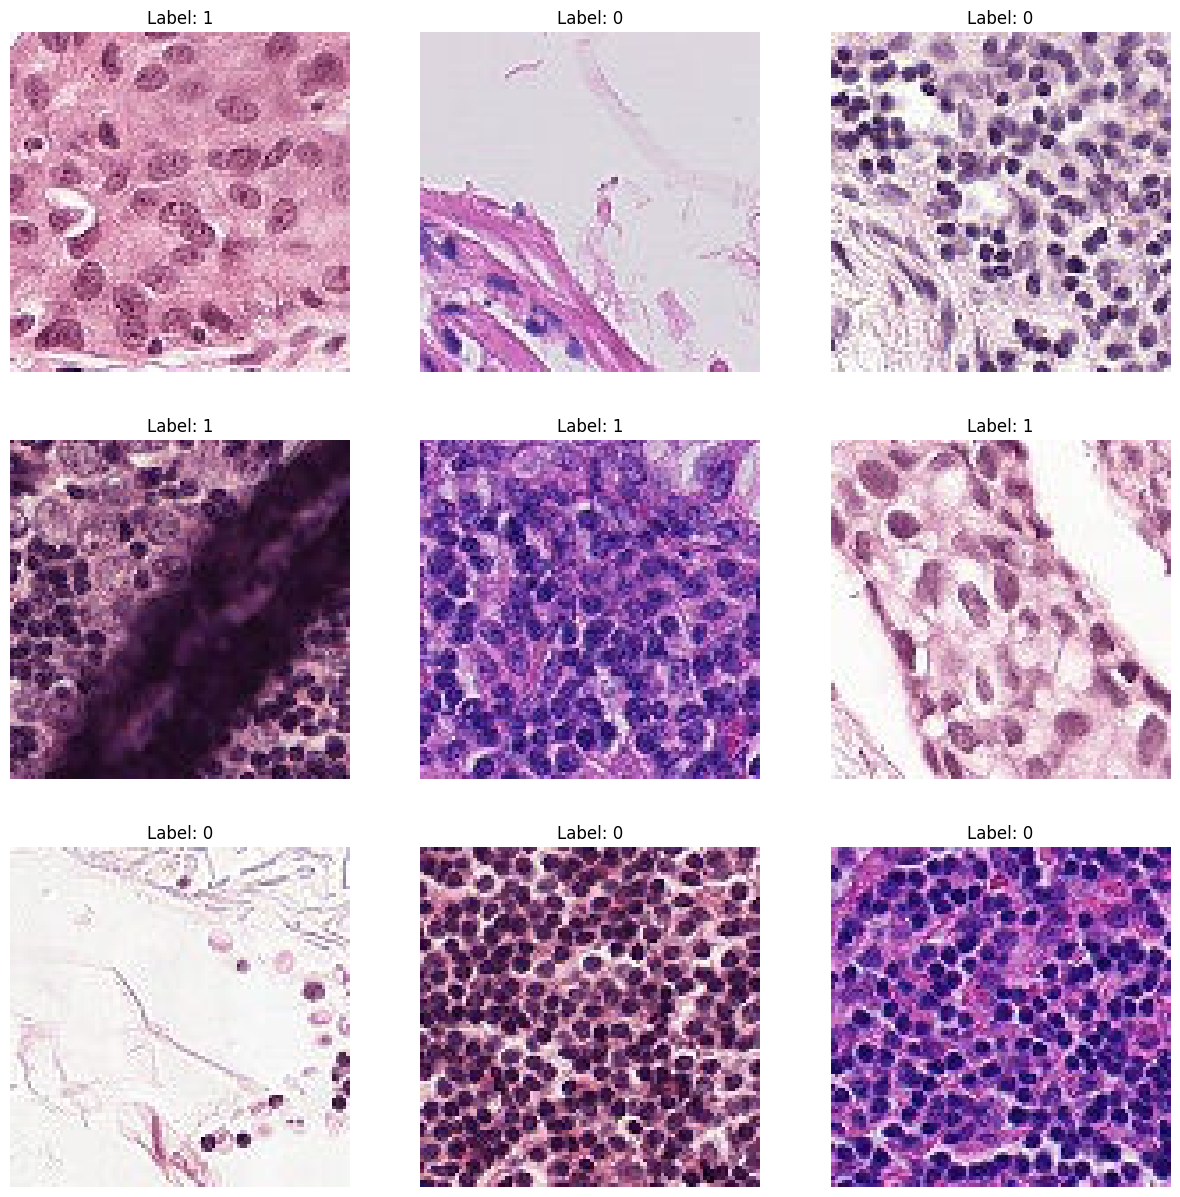

In [39]:
# Load labels
labels_df = pd.read_csv(LABELS_PATH)
labels = dict(zip(labels_df['id'], labels_df['label']))

#set labels_dict
labels_dict = labels_df.set_index('id')['label'].to_dict()

# Number of images to display
num_images_to_display = 9

# Load and display images from the training directory
train_images, train_filenames = load_images_from_folder(TRAIN_DIR, num_images_to_display)
display_images(train_images, train_filenames, labels, columns=3)


In [47]:
from tensorflow.keras import datasets, layers, models

def make_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))


    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(3, activation = 'softmax'))
    return model
model = make_model()

In [48]:
# Function to load images from a directory
def load_images_from_directory(directory, labels_dict, size_train, size_test):
    train_images = []
    test_images=[]
    train_labels = []
    test_labels=[]
    for i, filename in enumerate(os.listdir(directory)):
        if i == size_train+size_test:
            break
        if filename.endswith(".tif"):
            img_path = os.path.join(directory, filename)
            img = load_img(img_path, target_size=(96, 96))  # Change target_size to match image size
            img_array = img_to_array(img) / 255.0
            label=labels_dict.get(filename.split('.')[0], -1)
            if i<size_train:
                train_images.append(img_array)
                train_labels.append(label)
            else:
                test_images.append(img_array)
                test_labels.append(label)
    return np.array(train_images), np.array(train_labels), np.array(test_images), np.array(test_labels) if labels else None

In [38]:
labels_df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 526ms/step - accuracy: 0.6687 - loss: 0.6536 - val_accuracy: 0.7680 - val_loss: 0.5092
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 531ms/step - accuracy: 0.7844 - loss: 0.4643 - val_accuracy: 0.7490 - val_loss: 0.5116
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 527ms/step - accuracy: 0.7875 - loss: 0.4592 - val_accuracy: 0.7940 - val_loss: 0.4639
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 522ms/step - accuracy: 0.7952 - loss: 0.4400 - val_accuracy: 0.7830 - val_loss: 0.4779
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 525ms/step - accuracy: 0.8025 - loss: 0.4393 - val_accuracy: 0.8000 - val_loss: 0.4513
32/32 - 2s - 66ms/step - accuracy: 0.8040 - loss: 0.4418
Test accuracy: 0.8040000200271606


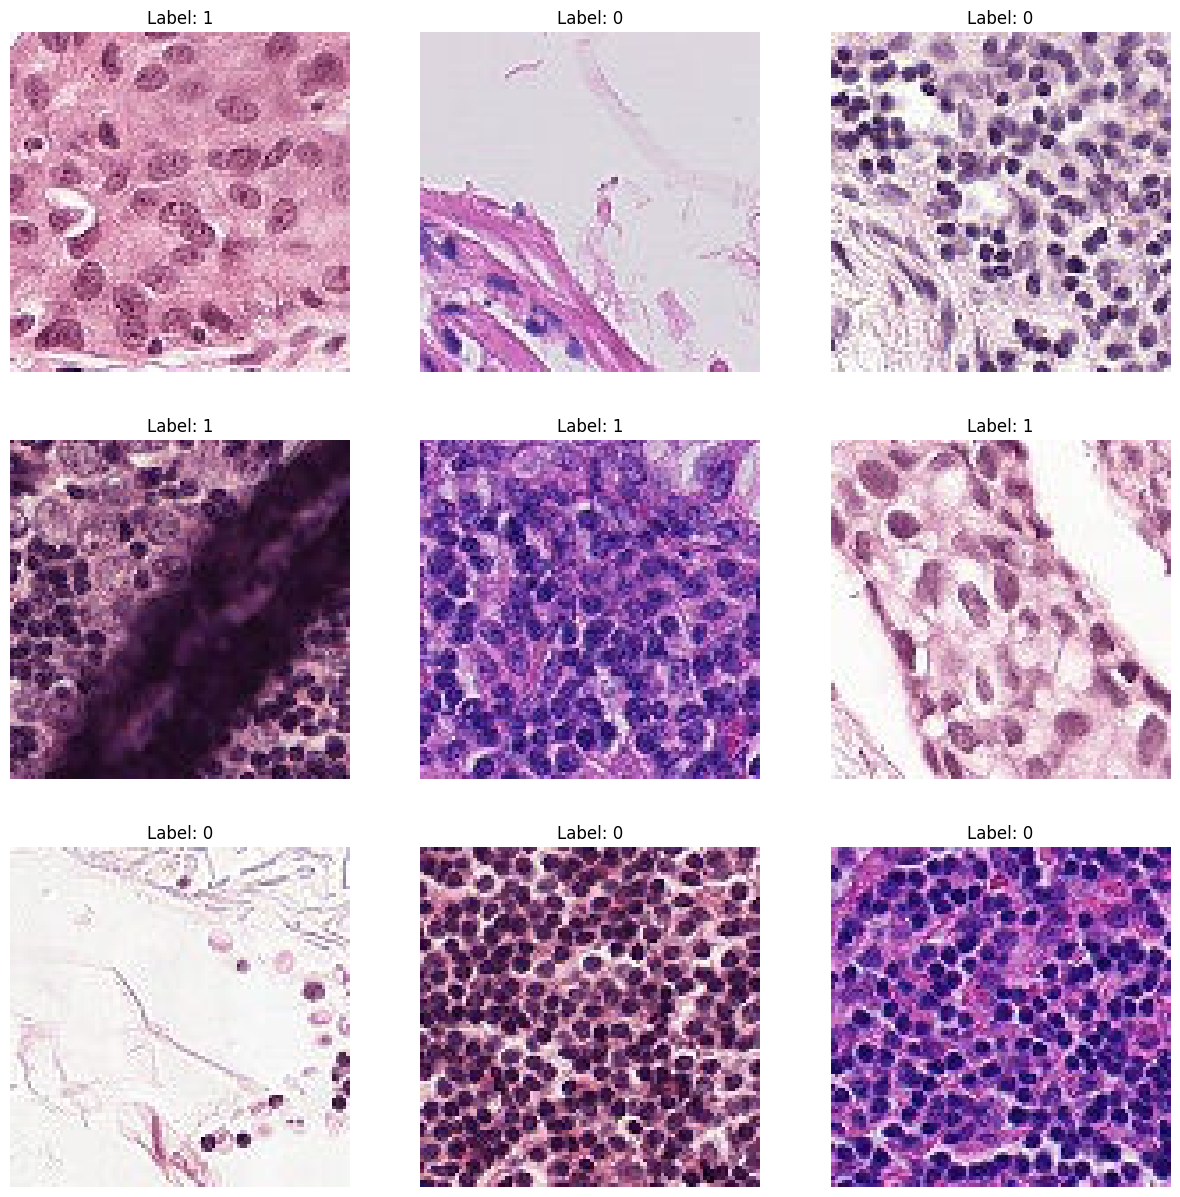

In [50]:

# Load and preprocess the data
train_images, train_labels, test_images, test_labels  = load_images_from_directory(TRAIN_DIR, labels_dict, size_train=10000, size_test=1000)

# One-hot encode labels
train_labels = to_categorical(train_labels, num_classes=3)
test_labels = to_categorical(test_labels, num_classes=3)

# Split train data into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Create and compile the model
model = make_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(val_images, val_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc}')

# Display images from the training directory
num_images_to_display = 9
train_images_sample, train_filenames = load_images_from_folder(TRAIN_DIR, num_images_to_display)
display_images(train_images_sample, train_filenames, labels_dict, columns=3)

# Display images from the test directory
# test_images_sample, test_filenames = load_images_from_folder(TEST_DIR, num_images_to_display)
# display_images(test_images_sample, test_filenames, labels_dict, columns=3)

In [17]:
train_images.shape

(8000, 96, 96, 3)

In [21]:
test_images.shape

(1000, 96, 96, 3)

In [34]:
#checks one-hot, goes to the last element of each row
#if it's zero then it's known, if it's one it's uknown
np.sum(train_labels[:,-1])

0.0

In [35]:
#the test is all uknown 
np.sum(test_labels[:,-1])

1000.0